# Disparity Calculation Using PiML and SolasAI

## Introduction



## Import Libraries and Data

In [44]:
import pandas as pd
import numpy as np
import plotly.io as pio
import solas_disparity as sd
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
from piml import Experiment
from piml.models import ExplainableBoostingClassifier
from IPython.display import display, Markdown


# pio.renderers.default = "svg"
pd.set_option('display.max_columns', 1000)
np.random.seed(161803)

# For the notebook, I didn't want the plots to take up too much room, but also didn't want to delete the code that creates them.  Change this to `True` to get PiML's extended output.
show_piml_results = False

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [45]:
df = pd.read_csv('segmented_friedman_1.csv.gz', index_col=0)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

We rename the protected/reference columns to be common values (Minority / Majority and Age>=62 / Age<62).  This is just to make the results shown in a way that is likely to be familiar to readers.

In [46]:
df.rename(
    columns={
        'protected_1': 'Minority',
        'reference_1': 'Majority',
        'protected_2': 'Age >= 62',
        'reference_2': 'Age < 62',
    },
    inplace=True,
)

protected_groups = ['Minority', 'Age >= 62']
reference_groups = ['Majority', 'Age < 62']
group_categories = ['Race', 'Age']

s_list = list(df['Segment'].unique())
s_list = dict(zip(s_list, ['S' + x.split(' ')[1].zfill(2) for x in s_list]))
df['Segment'].replace(to_replace=s_list, inplace=True)

df.sample(n=5)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Segment,x1,x2,x3,x4,x5,y,noise,bad,Minority,Majority,Age >= 62,Age < 62,Best Linear Estimate of Y,Best Logistic Estimate of BAD
54848,S15,0.152803,0.325204,0.054422,1.200922,-1.199056,-1.979842,-2.560992,0,0.025988,0.974012,0,1,0.542517,0.058137
53189,S14,0.276718,-0.256765,-0.396483,-1.163135,0.258974,-0.613252,-0.833580,0,0.130467,0.869533,0,1,0.185917,0.100152
16320,S06,1.160212,0.882936,0.149230,0.135407,-0.970423,1.489340,1.574834,0,0.946943,0.053057,0,1,-0.085023,0.060697
816,S04,0.576667,0.427731,-1.746224,-1.137797,0.664875,1.327499,-3.627437,0,0.710901,0.289099,0,1,5.078846,0.886537
15022,S06,-0.854609,2.036090,-0.518368,-1.833483,0.521418,1.393193,0.838377,0,0.516348,0.483652,1,0,0.557428,0.118042


Create a list of Features, Labels, and a helper dict that holds information and allows the user to easily access the protected and reference group information.

In [47]:
features = ['x1', 'x2', 'x3', 'x4', 'x5', 'Segment']
label = 'bad'

common_disp_info = dict(
    protected_groups=protected_groups,
    reference_groups=reference_groups,
    group_categories=group_categories,
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Build and Explain a Model Using PiML

In [48]:
exp = Experiment()
exp.data_loader(df)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Segment,x1,x2,x3,x4,x5,y,noise,bad,Minority,Majority,Age >= 62,Age < 62,Best Linear Estimate of Y,Best Logistic Estimate of BAD
0,S01,-2.697781,-0.642254,0.370297,0.748018,-1.424125,-1.085025,-0.785855,0.0,0.173852,0.826148,1.0,0.0,-0.331529,0.066508
1,S01,1.256522,-1.501616,0.662731,0.178733,-0.132569,0.67651,0.421849,0.0,0.154426,0.845574,0.0,1.0,0.257137,0.11331
2,S01,-0.064053,-0.617098,-1.289419,-0.901302,-0.08264,1.7669,-0.975268,0.0,0.302137,0.697863,1.0,0.0,2.834243,0.640497
3,S01,-0.749886,1.506928,-0.841099,-0.220455,-0.809758,0.216603,-1.446028,0.0,0.224366,0.775634,0.0,1.0,1.713377,0.364506
4,S01,1.695371,-0.526214,-0.016714,1.251901,-0.468502,4.418227,3.781825,1.0,0.103299,0.896701,1.0,0.0,0.609743,0.152934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63235,S15,0.865633,0.244643,1.629236,-0.410947,0.970538,0.70914,-0.860192,0.0,0.208858,0.791142,1.0,0.0,1.556579,0.163854
63236,S15,-1.273168,0.628253,0.867698,0.372415,1.096055,1.256282,0.973674,0.0,0.711011,0.288989,0.0,1.0,0.294422,0.05366
63237,S15,0.997929,0.658184,-0.618099,-0.600917,-0.528071,-0.022656,-1.237266,0.0,0.011205,0.988795,1.0,0.0,1.173896,0.103913
63238,S15,1.349351,0.576261,-0.295542,0.871115,-3.244451,0.467361,-0.106663,0.0,0.752349,0.247651,0.0,1.0,0.502698,0.046988


In [49]:
exp.data_summary(
    feature_exclude=[x for x in df if x not in features + [label]],
    feature_type={key: 'numerical' if key != 'Segment' else 'categorical' for key in features}
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='Data Shape:(63240, 15)')

In [50]:
exp.data_prepare(
    target=label,
    task_type='Classification',
    test_ratio=0.2,
    random_state=31415,
    with_display=True,
)

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,0,1
0,Excluded columns,"[y, noise, Minority, Majority, Age >= 62, Age < 62, Best Linear Estimate of Y, Best Logistic Estimate of BAD]"
1,Target variable,bad
2,Sample weight,None
3,Task type,Classification
4,Split method,Random
5,Test ratio,0.2
6,Random state,31415


In [51]:
if show_piml_results:
    exp.eda(
        show='all',
        uni_feature='Segment',
        bi_features=['x1', 'x2'],
        multi_type='correlation_heatmap',
    )

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [52]:
ebm = ExplainableBoostingClassifier()
exp.model_train(model=ebm, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_result')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value="<p class='notification info'>Register EBM Done</p>")

,ACC,AUC,Recall,Precision,F1
,,,,,
Train,0.8530,0.8558,0.4938,0.7843,0.6060
Test,0.8477,0.8465,0.4790,0.7830,0.5944
Gap,-0.0053,-0.0092,-0.0148,-0.0012,-0.0117


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

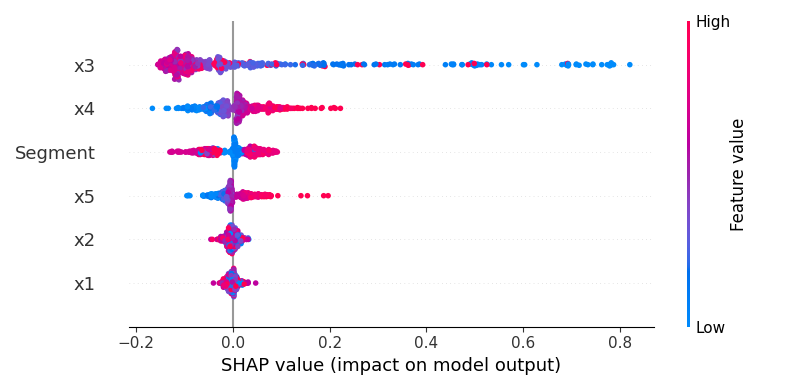

In [54]:
exp.model_explain(
    model='EBM',
    show='global_shap_summary',
    sample_size=500,
)
if show_piml_results:
    exp.model_interpret(model='EBM', show='global_fi')
    exp.model_interpret(model='EBM', show='global_effect_plot', bi_features=['x1', 'x2'])
    # for f_i in features:
    #     exp.model_interpret(model='EBM', show='global_effect_plot', uni_feature=f_i)

PiML Uses the random seed for train_test_split sent into `piml.Experiment().data_prepare()`, so we can get the same train/test split using the following code (I couldn't figure out how to do this via PiML directly).  

Note that at SolasAI, we use the train/validation/test nomenclature but PiML uses train/test.  Clearly we are correct.  :-)

In [55]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df, test_size=0.2, random_state=31415)
train = train.copy()
valid = valid.copy()

# Double-Check that the random_state assumption is correct.
check_same_split = pd.DataFrame(data=exp.get_raw_data().train_x, columns=exp.get_feature_names())
assert np.all(np.abs(train[['x1', 'x2', 'x3', 'x4', 'x5']].values - check_same_split[['x1', 'x2', 'x3', 'x4', 'x5']].values) == 0), "PiML and train_test_split() not producing the same train/test sets"
del check_same_split

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

Calculate predicted probabilities from the EBM for the training / validation splits.

In [58]:
train['EBM Prediction'] = exp.get_model(model='EBM').predict_proba(exp.get_raw_data().train_x)[:, 1]
valid['EBM Prediction'] = exp.get_model(model='EBM').predict_proba(exp.get_raw_data().test_x)[:, 1]

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

We know the functional form that the data takes: it is the Friedman #1 with segmentation and custom coefficients.  Given that we know this information, when we created the dataset, we were able to create the "best possible" predictions using a logit and the features specified 
exactly as they entered the data generating process.  In order to test whether the EBM does a decent job finding the data's functional form, we compare the predictions from the PiML EBM to the "best possible" predictions.  We also calculate train/validation KS and AUC values for the EBM model itself.

Below, we perform another comparison of the best possible model predictions to the EBM logit.  Here, the OLS coefficients would ideally be beta0 = 0 and beta1 = 1 with an r^2 = 1.  Obviously, it is unlikely that we will get exactly that.  

## Disparity Analysis Using SolasAI

Here, we begin the analysis of the PiML EBM model's predictions assuming that they are used to generate some rankable outcome for consumers.  

### Outcomes Analyzed

Analyses are performed on three `outcomes` generated using the model predictions.  These are:
1. The model's output itself, in probability (`valid['EBM Prediction']`).
2. A binary "Offer" or "No Offer" outcome based on a single threshold cutoff (`valid['Offer']`).
3. Using two cutoff values, we create a waterfall of offers, where the worst scoring group gets no offer, the middle scoring group gets a "good" offer, and the best scoring consumers get the "best" offer (`valid['Tiered Offer']`).

Note, in this simulated data a lower model score is considered a more favorable result for the consumer.  A real-world exmaple of this is credit default models, where the lower the score, the lower the probability of default.  
A lower probability of default is more likely to get an offer or more likely to get a better offer.  Thus, a low score is a favorable outcome from the perspective of the person being scored.

### Disparity Tests Performed


We perform the following tests:
1. `Standardized Mean Difference (SMD)` in the model predictions
2. `Adverse Impact Ratio (AIR) by Quantile` of model predictions.  Decile cutoffs were used for the quantiles.
3. Using the single "Offer" calculated, a standard `AIR` is calculated.
4. Using the single "Offer" calculated, a standard `Odds Ratio (OR)` is calculated.
5. Using the single "Offer" calculated, we create a `Segmented AIR`.  This calculates AIRs for indvidual "segments" of the data and then calculates aggregated AIRs and CMH statistical tests.
6. Using the tiered set of offers, we run a `Categorical AIR`, which calculates disparity comparing: 
    - best vs (good + no offer), and 
    - (best + good) v. no offer.

#### Calculate Offers

This code calculates the single and tiered offers for the EBM model.

In [59]:
single_decision_threshold = 0.15
good_offer_threshold = 0.20
best_offer_threshold = 0.05

valid['Offer'] = (valid['EBM Prediction'] <= single_decision_threshold).astype(int)

valid['Tiered Offer'] = np.where(
    valid['EBM Prediction'] <= best_offer_threshold, 
    'Best Offer', 
    np.where(
        valid['EBM Prediction'] <= good_offer_threshold, 
        'Good Offer', 
        'No Offer'
    )
)
display(valid['Offer'].value_counts(dropna=False, normalize=True))
display(valid['Tiered Offer'].value_counts(dropna=False, normalize=True))

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

1    0.575585
0    0.424415
Name: Offer, dtype: float64

Good Offer    0.487034
No Offer      0.333096
Best Offer    0.179870
Name: Tiered Offer, dtype: float64

#### _Standardized Mean Difference (SMD) of Model Predictions_

In [60]:
smd = sd.standardized_mean_difference(
    group_data=valid,
    **common_disp_info,
    outcome=valid['EBM Prediction'],
    smd_threshold=30,
    label=valid[label], 
    lower_score_favorable=True,
)
smd

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: SMD

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ SMD Threshold                                            │ 30.0                                                 │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

\* Percent Missing: Age: 0.00%, Race: 0.00%

## SMD Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Average Label,Average Outcome,Std. Dev. of Outcomes,SMD,P-Values,Practically Significant
Race,Minority,Majority,"12,648",0.00%,"6,005.0",0.35,0.29,0.25,45.617,0.000,Yes
Race,Majority,,"12,648",0.00%,"6,643.0",0.12,0.17,0.25,,,
Age,Age >= 62,Age < 62,"12,648",0.00%,"6,392.0",0.23,0.23,0.25,0.928,0.602,No
Age,Age < 62,,"12,648",0.00%,"6,256.0",0.23,0.23,0.25,,,


#### _Adverse Impact Ratio (AIR) by Decile of Model Predictions_

In [39]:
air_by_quantile = sd.adverse_impact_ratio_by_quantile(
    group_data=valid,
    **common_disp_info,
    outcome=valid['EBM Prediction'],
    air_threshold=0.9,
    percent_difference_threshold=0.0,
    label=valid[label],
    lower_score_favorable=True,
    quantiles=[x / 100 for x in range(10, 101, 10)]
)
air_by_quantile

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: AIR by Quantile

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ AIR Threshold                                            │ 0.9                                                  │
│ % Diff Threshold                                         │ 0.0                                                  │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

## AIR by Quantile Summary Table

Group Category,Group,Reference Group,Quantile,Quantile Cutoff,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Minority,Majority,10.0%,0.035844,"12,648",0.00%,"6,005.0","3,888.6",64.76%,383.7,6.39%,6.88%,0.482,0.000,Yes,412.905108
Race,Majority,,10.0%,0.035844,"12,648",0.00%,"6,643.0","5,813.4",87.51%,881.3,13.27%,,,,,
Age,Age >= 62,Age < 62,10.0%,0.035844,"12,648",0.00%,"6,392.0","4,897.0",76.61%,640.0,10.01%,-0.02%,1.002,0.991,No,
Age,Age < 62,,10.0%,0.035844,"12,648",0.00%,"6,256.0","4,805.0",76.81%,625.0,9.99%,,,,,
Race,Minority,Majority,20.0%,0.053450,"12,648",0.00%,"6,005.0","3,888.6",64.76%,855.9,14.25%,10.95%,0.566,0.000,Yes,657.506267
Race,Majority,,20.0%,0.053450,"12,648",0.00%,"6,643.0","5,813.4",87.51%,"1,674.1",25.20%,,,,,
Age,Age >= 62,Age < 62,20.0%,0.053450,"12,648",0.00%,"6,392.0","4,897.0",76.61%,"1,266.0",19.81%,0.40%,0.980,0.591,No,
Age,Age < 62,,20.0%,0.053450,"12,648",0.00%,"6,256.0","4,805.0",76.81%,"1,264.0",20.20%,,,,,
Race,Minority,Majority,30.0%,0.072239,"12,648",0.00%,"6,005.0","3,888.6",64.76%,"1,335.4",22.24%,14.79%,0.601,0.000,Yes,887.941617
Race,Majority,,30.0%,0.072239,"12,648",0.00%,"6,643.0","5,813.4",87.51%,"2,459.6",37.03%,,,,,


#### _Adverse Impact Ratio (AIR) Assuming a Single Offer_

In [40]:
air = sd.adverse_impact_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    label=valid[label],
)
air

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Adverse Impact Ratio

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ AIR Threshold                                            │ 0.8                                                  │
│ % Diff Threshold                                         │ 0.0                                                  │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

\* Percent Missing: Age: 0.00%, Race: 0.00%

## Adverse Impact Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Minority,Majority,"12,648",0.00%,"6,005.0","2,116.4",35.24%,"2,826.9",47.08%,19.96%,0.702,0.000,Yes,1198.61037
Race,Majority,,"12,648",0.00%,"6,643.0",829.6,12.49%,"4,453.1",67.04%,,,,,
Age,Age >= 62,Age < 62,"12,648",0.00%,"6,392.0","1,495.0",23.39%,"3,675.0",57.49%,0.13%,0.998,0.896,No,
Age,Age < 62,,"12,648",0.00%,"6,256.0","1,451.0",23.19%,"3,605.0",57.62%,,,,,


#### _Segmented Adverse Impact Ratio (AIR) Assuming a Single Offer_

In [41]:
said = sd.segmented_adverse_impact_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    label=valid[label],
    segment=valid['Segment'],
    fdr_threshold=0.20,
)
said

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Segmented AIR

┌──────────────────────┬──────────────────────────────────────────────────────────────────────────────────────────┐
│ Protected Groups     │ Minority, Age >= 62                                                                      │
│ Reference Groups     │ Majority, Age < 62                                                                       │
│ Group Categories     │ Race, Age                                                                                │
│ AIR Threshold        │ 0.8                                                                                      │
│ % Diff Threshold     │ 0.0                                                                                      │
│ FDR Threshold        │ 0.2                                                                                      │
│ Segments             │ ['S13', 'S11', 'S15', 'S06', 'S05', 'S12', 'S14', 'S10', 'S03', 'S04', 'S09', 'S07',     │
│                      │ 'S08', 'S02', 'S01']                                                                     │
│ Affected Groups      │ Minority                                                                                 │
│ Affected Reference   │ Majority                                                                                 │
│ Affected Categories  │ Race                                                                                     │
└──────────────────────┴──────────────────────────────────────────────────────────────────────────────────────────┘

## Segmented AIR Summary Table

Group Category,Group,Reference Group,Segment,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,AIR,P-Values,Benjamani-Hochberg Critical Value,Practically Significant
Race,Minority,Majority,S13,"2,978",0.00%,"1,424.6",625.2,43.89%,471.7,33.11%,0.619,0.000,,Yes
Race,Majority,,S13,"2,978",0.00%,"1,553.4",265.8,17.11%,830.3,53.45%,,,,
Age,Age >= 62,Age < 62,S13,"2,978",0.00%,"1,521.0",462.0,30.37%,664.0,43.66%,0.997,0.971,,No
Age,Age < 62,,S13,"2,978",0.00%,"1,457.0",429.0,29.44%,638.0,43.79%,,,,
Race,Minority,Majority,S11,"1,050",0.00%,529.5,228.2,43.10%,210.4,39.74%,0.690,0.000,,Yes
Race,Majority,,S11,"1,050",0.00%,520.5,78.8,15.13%,299.6,57.56%,,,,
Age,Age >= 62,Age < 62,S11,"1,050",0.00%,533.0,155.0,29.08%,262.0,49.16%,1.025,0.747,,No
Age,Age < 62,,S11,"1,050",0.00%,517.0,152.0,29.40%,248.0,47.97%,,,,
Race,Minority,Majority,S15,"2,043",0.00%,990.8,280.9,28.35%,570.6,57.59%,0.740,0.000,,Yes
Race,Majority,,S15,"2,043",0.00%,"1,052.2",89.1,8.47%,819.4,77.87%,,,,


#### _Odds Ratio (OR) Assuming Single Offer_

In [42]:
odds_ratio = sd.odds_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Offer'],
    odds_ratio_threshold=0.9,
    percent_difference_threshold=0.0,
    label=valid[label],
)
odds_ratio

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Odds Ratio

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ Odds Ratio Threshold                                     │ 0.9                                                  │
│ % Diff Threshold                                         │ 0.0                                                  │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

\* Percent Missing: Age: 0.00%, Race: 0.00%

## Odds Ratio Summary Table

Group Category,Group,Reference Group,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Label Odds,Favorable,Percent Favorable,Odds,Percent Difference Favorable,Odds Ratio,P-Values,Practically Significant
Race,Minority,Majority,"12,648",0.00%,"6,005.0","2,116.4",35.24%,0.544265,"2,826.9",47.08%,0.889467,19.96%,0.437399,0.000,Yes
Race,Majority,,"12,648",0.00%,"6,643.0",829.6,12.49%,0.142700,"4,453.1",67.04%,2.033538,,,,
Age,Age >= 62,Age < 62,"12,648",0.00%,"6,392.0","1,495.0",23.39%,0.305289,"3,675.0",57.49%,1.352595,0.13%,0.994654,0.896,No
Age,Age < 62,,"12,648",0.00%,"6,256.0","1,451.0",23.19%,0.301977,"3,605.0",57.62%,1.359864,,,,


#### _Categorical Adverse Impact Ratio (AIR) Based on a Tiered Set of Offers_

In [43]:
cair = sd.categorical_adverse_impact_ratio(
    group_data=valid,
    **common_disp_info,
    outcome=valid['Tiered Offer'],
    air_threshold=0.8,
    percent_difference_threshold=0.0,
    label=valid[label],
    ordinal_categories=['No Offer', 'Good Offer', 'Best Offer'],
)
cair

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## Disparity Calculation: Categorical AIR

┌──────────────────────────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Protected Groups                                         │ Minority, Age >= 62                                  │
│ Reference Groups                                         │ Majority, Age < 62                                   │
│ Group Categories                                         │ Race, Age                                            │
│ Affected Groups                                          │ Minority                                             │
│ Affected Reference                                       │ Majority                                             │
│ Affected Categories                                      │ Race                                                 │
└──────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────┘

## Categorical AIR Summary Table

Group Category,Group,Reference Group,Category,Category Ordinality,Observations,Percent Missing,Total,Label Favorable,Percent Label Favorable,Favorable,Percent Favorable,Percent Difference Favorable,AIR,P-Values,Practically Significant,Shortfall
Race,Minority,Majority,No Offer,0,"12,648",0.00%,"6,005.0","6,005.0",100.00%,"6,005.0",100.00%,0.00%,1.000,1.000,No,
Race,Majority,,No Offer,0,"12,648",0.00%,"6,643.0","6,643.0",100.00%,"6,643.0",100.00%,,,,,
Age,Age >= 62,Age < 62,No Offer,0,"12,648",0.00%,"6,392.0","6,392.0",100.00%,"6,392.0",100.00%,0.00%,1.000,1.000,No,
Age,Age < 62,,No Offer,0,"12,648",0.00%,"6,256.0","6,256.0",100.00%,"6,256.0",100.00%,,,,,
Race,Minority,Majority,Good Offer,1,"12,648",0.00%,"6,005.0","2,116.4",35.24%,"3,395.7",56.55%,19.31%,0.745,0.000,Yes,1159.664458
Race,Majority,,Good Offer,1,"12,648",0.00%,"6,643.0",829.6,12.49%,"5,039.3",75.86%,,,,,
Age,Age >= 62,Age < 62,Good Offer,1,"12,648",0.00%,"6,392.0","1,495.0",23.39%,"4,255.0",66.57%,0.25%,0.996,0.782,No,
Age,Age < 62,,Good Offer,1,"12,648",0.00%,"6,256.0","1,451.0",23.19%,"4,180.0",66.82%,,,,,
Race,Minority,Majority,Best Offer,2,"12,648",0.00%,"6,005.0",0.0,0.00%,753.5,12.55%,10.36%,0.548,0.000,Yes,621.940281
Race,Majority,,Best Offer,2,"12,648",0.00%,"6,643.0",0.0,0.00%,"1,521.5",22.90%,,,,,
